In [76]:
import yfinance as yf
import pandas as pd
import numpy as np

In [155]:
import yfinance as yf
from datetime import datetime

# Define the ticker symbol
ticker = 'TATAPOWER.NS'

# Calculate start date for approximately 5000 rows (20 years back from today)
start_date = "2004-01-01"
end_date = datetime.now().strftime("%Y-%m-%d")  # Set the end date to today's date

# Download historical data from the ticker
data = yf.download(ticker, start=start_date, end=end_date)

# Display the first few rows
print(data.tail())

# Save the dataset to a CSV file
data.to_csv(f'{ticker}_historical_data.csv')


[*********************100%***********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2024-10-30  426.049988  433.299988  421.850006  427.000000  427.000000   
2024-10-31  430.500000  444.799988  420.799988  440.049988  440.049988   
2024-11-01  444.000000  448.450012  442.100006  445.450012  445.450012   
2024-11-04  446.250000  446.799988  426.049988  429.049988  429.049988   
2024-11-05  429.000000  434.850006  425.850006  434.100006  434.100006   

              Volume  
Date                  
2024-10-30   9699786  
2024-10-31  29693039  
2024-11-01   4387971  
2024-11-04  13264369  
2024-11-05   8889823  


In [156]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-01-01,30.880548,31.170053,30.359440,31.088026,21.882357,11262763
2004-01-02,31.247255,31.942068,31.218306,31.744240,22.344255,13283836
2004-01-05,31.860041,32.738209,31.546412,32.448704,22.840118,17074763
2004-01-06,32.907085,34.972221,32.231571,34.012032,23.940519,48400703
2004-01-07,34.065105,35.995140,33.688747,35.768360,25.176769,45343266


# EDA

Lets start on EDA Process

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

In [157]:
data.isnull().sum()  ## There is no Null Value

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [158]:
data.shape

(5157, 6)

In [159]:
data.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [160]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet import Prophet
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

# Load and prepare the data
data_new = data.sort_index()
data_new = data_new[['Close']]
train_size = int(len(data_new) * 0.8)
train_data, test_data = data_new[:train_size], data_new[train_size:]

# Function to calculate and store metrics
def evaluate_metrics(y_true, y_pred, model_name, results):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    results[model_name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse}

# Dictionary to store results
results = {}

### Model 1: Linear Regression ###
X_train = np.arange(len(train_data)).reshape(-1, 1)
y_train = train_data['Close']
X_test = np.arange(len(train_data), len(train_data) + len(test_data)).reshape(-1, 1)
y_test = test_data['Close']

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)
evaluate_metrics(y_test, y_pred_linear, "Linear Regression", results)

### Model 2: Prophet ###
prophet_data = data_new.reset_index().rename(columns={'Date': 'ds', 'Close': 'y'})
prophet_train = prophet_data.iloc[:train_size]

prophet_model = Prophet()
prophet_model.fit(prophet_train)

future = prophet_model.make_future_dataframe(periods=len(test_data))
forecast = prophet_model.predict(future)
y_pred_prophet = forecast['yhat'].iloc[-len(test_data):].values
evaluate_metrics(y_test, y_pred_prophet, "Prophet", results)

### Model 3: LSTM ###
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

def create_lstm_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 60
X_train_lstm, y_train_lstm = create_lstm_data(train_scaled, time_steps)
X_test_lstm, y_test_lstm = create_lstm_data(test_scaled, time_steps)

X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32)

y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)
evaluate_metrics(y_test[time_steps:], y_pred_lstm, "LSTM", results)

### Model 4: Random Forest Regressor ###
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
evaluate_metrics(y_test, y_pred_rf, "Random Forest Regressor", results)

### Model 5: Decision Tree Regressor ###
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
evaluate_metrics(y_test, y_pred_dt, "Decision Tree Regressor", results)

### Model 6: Support Vector Regressor (SVR) ###
svr_model = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)
evaluate_metrics(y_test, y_pred_svr, "Support Vector Regressor (SVR)", results)

### Model 7: XGBoost Regressor ###
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
evaluate_metrics(y_test, y_pred_xgb, "XGBoost Regressor", results)

# Display results as a DataFrame
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)


20:31:54 - cmdstanpy - INFO - Chain [1] start processing
20:31:56 - cmdstanpy - INFO - Chain [1] done processing


Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 0.0311
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0011
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0010
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 8.6570e-04
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 7.7816e-04
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 7.5688e-04
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 7.7385e-04
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - loss: 7.0748e-04
Epoch 9/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 5.7144e-04
Epoch 10/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 6.1497e-04
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step

Model Performance Comparison:
                                       MAE           MSE        RMSE
Linear Regression               150.833527  34082.263909  184.613824
Prophet                         203.874251  56498.887640  237.694947
LSTM      

Epoch 1/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 0.0369
Epoch 2/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 0.0011
Epoch 3/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 9.1175e-04
Epoch 4/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 8.2546e-04
Epoch 5/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 7.0505e-04
Epoch 6/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.0015
Epoch 7/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 5.2404e-04
Epoch 8/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 4.6927e-04
Epoch 9/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 5.0245e-04
Epoch 10/10
128/128 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 4.5142e-04
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
LSTM model performance evaluation on test data:
MAE: 24.08304138340577, MSE: 1384.2868970615598, RMSE: 37.206006196064095
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━

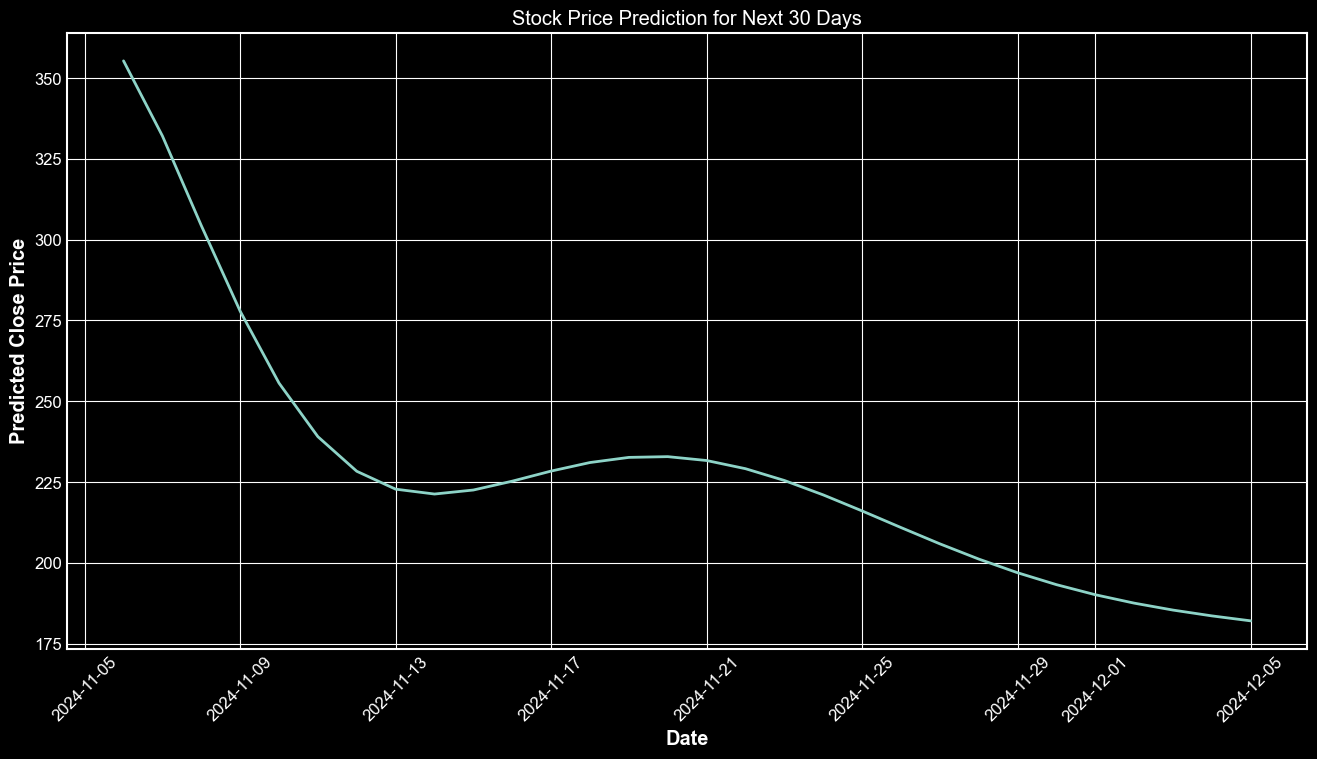

In [161]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime, timedelta
import pickle
import matplotlib.pyplot as plt

# Load your stock data
# Assuming 'data' contains the stock data with 'Date' and 'Close' columns
data_new = data.sort_index()
data_new = data_new[['Close']]

# Prepare data (80% train, 20% test split)
train_size = int(len(data_new) * 0.8)
train_data, test_data = data_new[:train_size], data_new[train_size:]

# Normalize the data (using MinMaxScaler)
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Prepare data for LSTM model (create sequences of 60 time steps)
def create_lstm_data(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 60
X_train_lstm, y_train_lstm = create_lstm_data(train_scaled, time_steps)
X_test_lstm, y_test_lstm = create_lstm_data(test_scaled, time_steps)

# Reshape data for LSTM (3D input format: [samples, time steps, features])
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Define LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1)
])

# Compile and fit the model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32)

# Predict and evaluate on test data
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)  # Inverse scaling
print("LSTM model performance evaluation on test data:")
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(test_data[time_steps:], y_pred_lstm)
mse = mean_squared_error(test_data[time_steps:], y_pred_lstm)
rmse = np.sqrt(mse)
print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}")

# Save the LSTM model and scaler as pickle files
with open('lstm_model.pkl', 'wb') as f:
    pickle.dump(lstm_model, f)
    
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Predict the next 30 days stock prices
# Use the last 60 days from the training data to predict the next 30 days
last_60_days = data_new[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)

X_input = last_60_days_scaled.reshape((1, last_60_days_scaled.shape[0], 1))

predictions = []
for i in range(30):  # Predict the next 30 days
    pred = lstm_model.predict(X_input)
    predictions.append(pred[0][0])
    X_input = np.append(X_input[:, 1:, :], pred.reshape(1, 1, 1), axis=1)

# Inverse scaling to get actual stock prices
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Prepare the dates for prediction
last_date = data_new.index[-1]
dates = [last_date + timedelta(days=i) for i in range(1, 31)]

# Create a dataframe for predictions
predicted_df = pd.DataFrame({'Date': dates, 'Predicted Close': predictions.flatten()})

# Display predictions
print(predicted_df)

# Plot the predictions
plt.plot(dates, predictions)
plt.title('Stock Price Prediction for Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Predicted Close Price')
plt.xticks(rotation=45)
plt.show()

# Download the pickle files for model and scaler (for use in deployment)
# You can download these files after running the code, or if running in a web environment, offer them for download
